In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import glob
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import __version__ as keras_version
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K


new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

In [3]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
labels = pd.read_csv('/a/data/fisheries_monitoring/data/detection_labels/boxes.csv',names = ["img", "x","y","w","h"])

In [9]:
def load_raw_data():
    raw_data = []
    raw_index = []
    raw_boxes = []
    for i in xrange(len(labels)):
        file_name = labels.iloc[i]["img"]
        path = '/a/data/fisheries_monitoring/data/train/' + file_name
        img = imread(path)
        box = labels.iloc[i][["x","y","w","h"]].values.astype(dtype = 'float32')
        raw_data.append(img)
        raw_index.append(file_name)
        raw_boxes.append(box)
    return raw_data, raw_boxes, raw_index

In [10]:
def resize_data_and_boxes(raw_data, raw_boxes, raw_index, new_width, new_height):
    resized_data = []
    resized_boxes = []
    for i in xrange(len(raw_data)):
        path = '/a/data/fisheries_monitoring/data/train/' + raw_index[i]
        old_width = raw_data[i].shape[1]
        old_height = raw_data[i].shape[0]
        old_x, old_y, old_w, old_h = raw_boxes[i]
        
        img = image.load_img(path, target_size=(new_width, new_height))
        img = image.img_to_array(img)
        resized_data.append(img)
        
        new_x = old_x * new_width / old_width
        new_y = old_y * new_height / old_height
        new_w = old_w * new_width / old_width
        new_h = old_h * new_height / old_height
        resized_boxes.append(np.array([new_x, new_y, new_w, new_h]))
    
    resized_data = np.array(resized_data)
    resized_data /= 255
    resized_boxes = np.array(resized_boxes)
    resized_index = np.array(raw_index)
    
    return resized_data, resized_boxes, resized_index

In [70]:
def visualize_prediction(img, true_box, pred_box = None):
    _, ax = plt.subplots(1, 1, figsize=(60, 9))
    ax.imshow(img)
    x, y, width, height = true_box
    ax.add_patch(
    patches.Rectangle(
        (x, y), # x,y
        width, # width
        height, # height
        hatch='\\',
        fill=False      # remove background
            )
        )
    if pred_box is not None:
        x, y, width, height = pred_box
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            width, # width
            height, # height
            hatch='-',
            fill=False      # remove background
                )
            )

In [18]:
raw_data, raw_target, raw_index = load_raw_data()
train_data, train_target, train_index = resize_data_and_boxes(raw_data, raw_target, raw_index, INPUT_WIDTH, INPUT_HEIGHT)

## Visualizing data and boxes

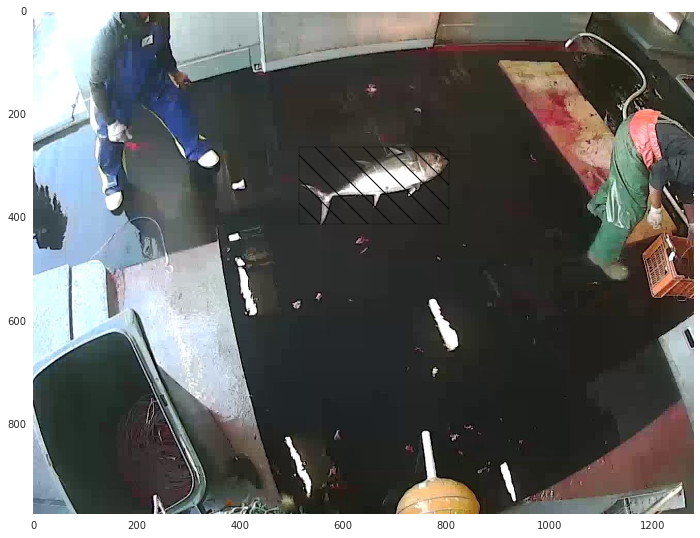

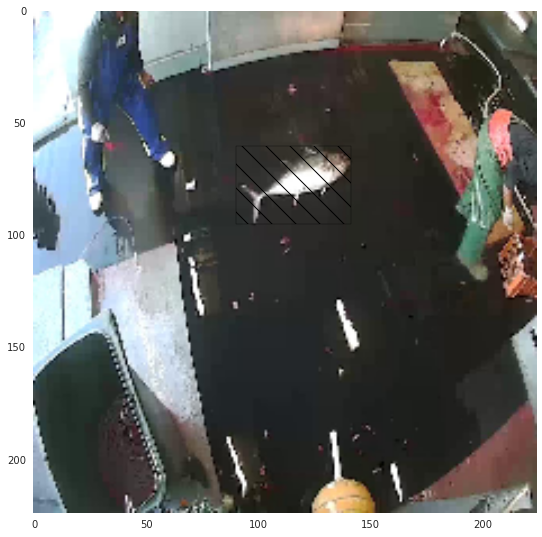

In [15]:
n = np.random.choice(len(X_train))
visualize_prediction(raw_X_train[n], raw_y_train[n])
visualize_prediction(X_train[n], y_train[n])

## Define model

In [16]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(224,224,3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4)(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error')

## Start training

In [43]:
batch_size = 16
nb_epoch = 50
random_state = 51

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

In [44]:
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, shuffle=True,
          verbose=2, validation_data=(X_test, y_test))

Train on 3496 samples, validate on 875 samples
Epoch 1/50
52s - loss: 303.3295 - val_loss: 398.3867
Epoch 2/50
52s - loss: 294.6525 - val_loss: 417.8719
Epoch 3/50
52s - loss: 295.8064 - val_loss: 421.7601
Epoch 4/50
52s - loss: 288.7853 - val_loss: 409.0133
Epoch 5/50
52s - loss: 285.8879 - val_loss: 425.1365
Epoch 6/50
52s - loss: 287.5957 - val_loss: 407.5834
Epoch 7/50
52s - loss: 288.5182 - val_loss: 422.6015
Epoch 8/50
52s - loss: 277.4894 - val_loss: 425.6821
Epoch 9/50
52s - loss: 285.7022 - val_loss: 451.9581
Epoch 10/50
52s - loss: 287.4573 - val_loss: 412.9993
Epoch 11/50
52s - loss: 274.8549 - val_loss: 394.8406
Epoch 12/50
52s - loss: 273.7108 - val_loss: 429.5316
Epoch 13/50
52s - loss: 273.0350 - val_loss: 403.6311
Epoch 14/50
52s - loss: 267.7430 - val_loss: 417.5690
Epoch 15/50
52s - loss: 267.7343 - val_loss: 401.7554
Epoch 16/50
52s - loss: 263.4780 - val_loss: 420.1166
Epoch 17/50
52s - loss: 264.8133 - val_loss: 416.6889
Epoch 18/50
52s - loss: 268.1609 - val_loss:

/a/h/jli04/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


## Prediction and visualization

In [45]:
y_pred = model.predict(X_test.astype('float32'), batch_size=batch_size, verbose=2)

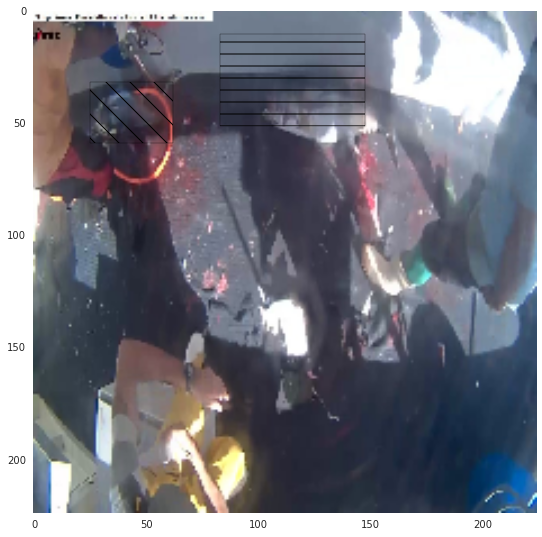

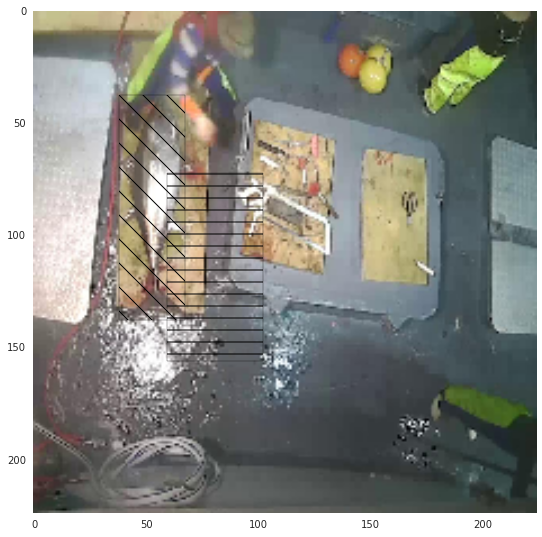

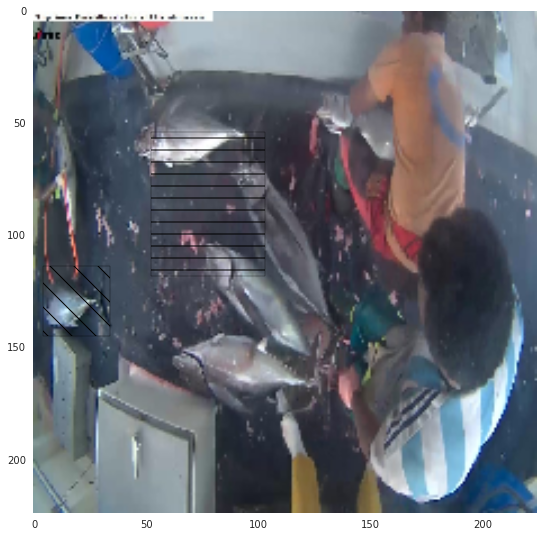

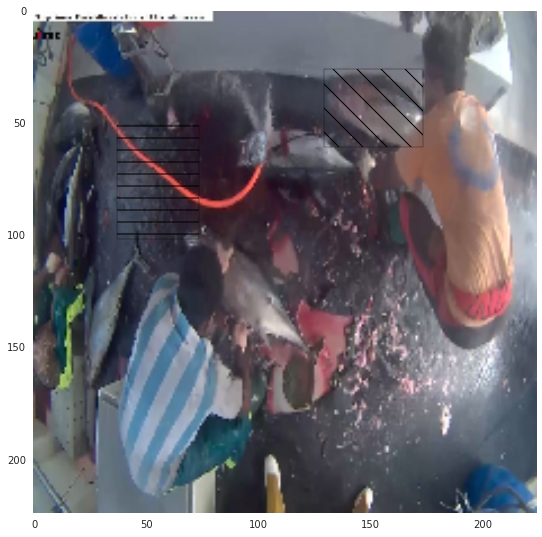

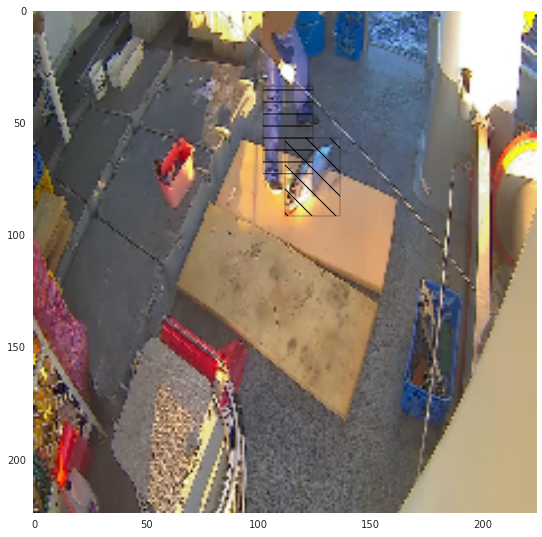

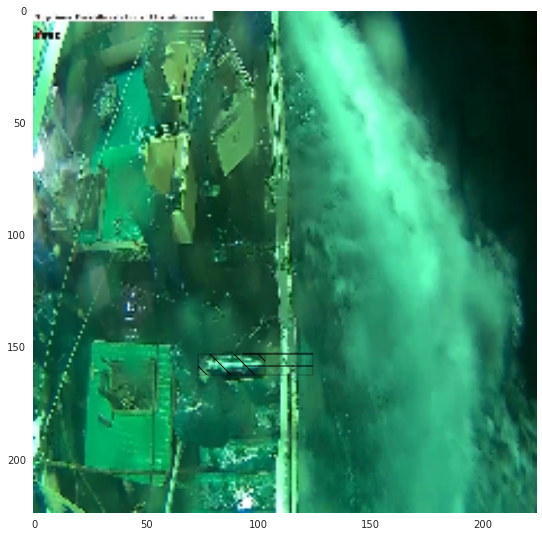

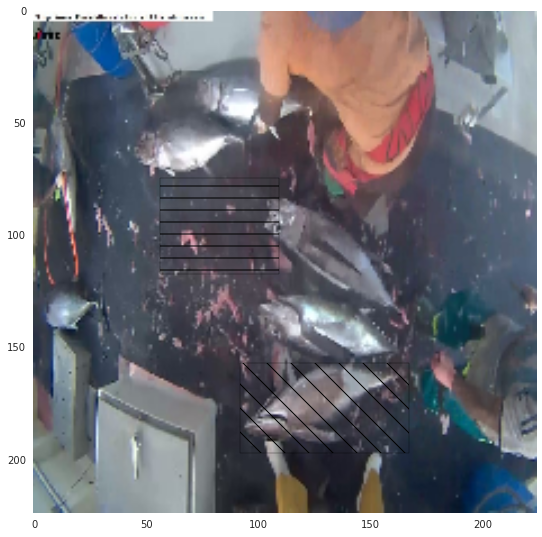

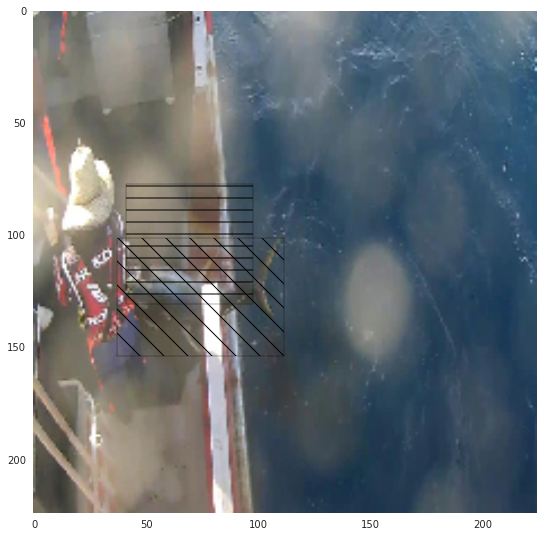

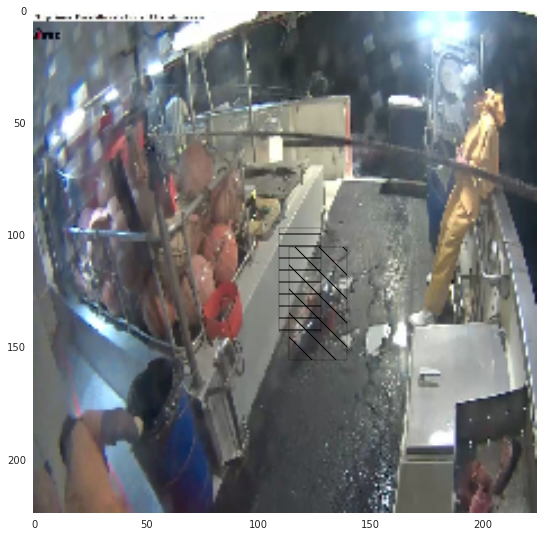

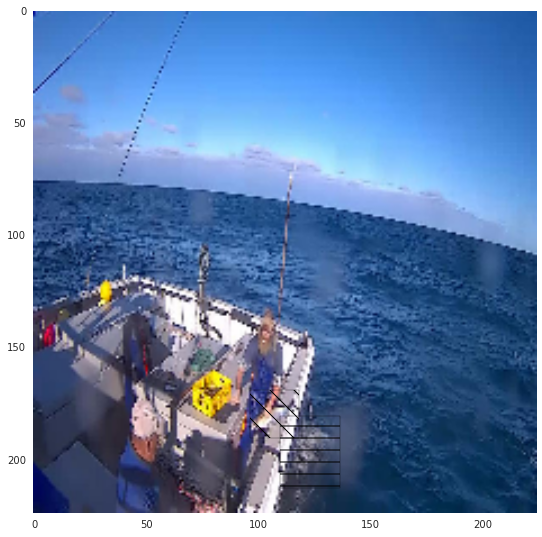

In [74]:
# The true boxes have the patch pattern of '\\' and predicted boxes have the patch pattern of '-'

for i in xrange(10):
    n = np.random.choice(len(X_test))
    visualize_prediction(X_test[n], y_test[n], y_pred[n])